In [414]:
import pandas as pd
import psycopg2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', None) # or 1000.

In [415]:
conn = psycopg2.connect(dbname="adsdb", user="adsdb", password="adsdb")

In [416]:
df_deaths = pd.read_sql('SELECT * from formatted.morticd_10_5_8f17_1642871335;', conn, params = dict(name="adsdb"))
df_demo = pd.read_sql('SELECT * from formatted.demographic_0_070d_1642871333;', conn, params = dict(name="adsdb"))
df_demo_labels = pd.read_sql('SELECT * from formatted.demographiclabels_0_070d_1642871333;', conn, params = dict(name="adsdb"))
df_country_deaths = pd.read_sql('SELECT * from formatted.countrycodes_0_8c41_1642871335;', conn, params = dict(name="adsdb"))
df_country_demo = pd.read_sql('SELECT * from formatted.demographiccountry_0_070d_1642871333;', conn, params = dict(name="adsdb"))

In [417]:
c = ["Country", "Year", "Cause", "Deaths1"]
df_deaths = df_deaths[c]

In [418]:
df_mortality_long = df_deaths.pivot_table(index=("Year", "Country"), columns="Cause", aggfunc=sum)
df_mortality_long = df_mortality_long.loc[:, (['Deaths1'], ['AAA'])]
df_mortality_long = df_mortality_long.xs(key='AAA', level='Cause', axis=1)

In [419]:
df_mortality = df_mortality_long.join(df_country_deaths.set_index("Country"), on="Country")

In [420]:
df_demo = df_demo.set_index("CountryId").join(df_country_demo.set_index("Code"), on="CountryId")

In [421]:
df_demo = df_demo.set_index("IndicatorId").join(df_demo_labels.set_index("Indicator"), on="IndicatorId")

In [422]:
df_demo_pivoted = df_demo.set_index(["Year", "Name"]).pivot_table(index=("Year", "Name"), columns="Description", values="Value", aggfunc=sum)

In [423]:
df_final = df_mortality.join(df_demo_pivoted, on=("Year","Name")).reset_index()

# Model

In [425]:
df_final.shape

(163, 37)

In [426]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold, GridSearchCV
from sklearn.inspection import permutation_importance

In [427]:
# Droping columns with NaN in predictor
df = df_final[df_final['Deaths1'].notna()]
df = df[df['Total population (thousands)'].notna()]
df['Deaths/Pop'] = (df['Deaths1']/(df['Total population (thousands)']*1000))*100
df = df.drop(columns=['Deaths1', 'Name'])
df.head()

,Year,Country,"Fertility rate, total (births per woman)",GDP (constant LCU),GDP (current LCU),GDP (current US$),GDP deflator (base year varies by country),GDP growth (annual %),GDP per capita (current LCU),GDP per capita (current US$),...,Population aged 25-64 years (thousands),Population aged 65 years or older (thousands),Population growth (annual %),Poverty headcount ratio at $3.20 a day (PPP) (% of population),"Prevalence of HIV, total (% of population ages 15-49)",Price level ratio of PPP conversion factor (GDP) to market exchange rate,Rural population (% of total population),Total debt service (% of GNI),Total population (thousands),Deaths/Pop
0,2017,1125,3.370,3.470000e+12,3.470000e+12,2.357337e+11,100.00000,4.18122,35979.95450,2444.29039,...,42152.853,5003.376,2.09083,28.9,0.1,0.22192,57.295,2.89639,96442.591,0.567392
2,2017,1300,1.440,3.452793e+11,4.572010e+11,1.325935e+10,132.41482,3.81415,361534.31919,10484.90583,...,698.756,138.484,0.09019,2.2,1.2,0.48960,59.159,NaN,1264.499,0.784026
5,2017,1520,2.219,7.108445e+10,9.629830e+10,3.980255e+10,135.47028,1.91806,8422.51473,3481.24111,...,6080.198,920.659,1.13907,NaN,0.1,0.32826,31.358,7.85130,11433.443,0.247476
6,2017,2005,NaN,NaN,7.673787e+08,NaN,NaN,NaN,52617.84929,NaN,...,8.312,1.334,NaN,NaN,NaN,NaN,NaN,NaN,14.584,0.589687
7,2017,2010,1.999,3.274480e+09,3.963540e+09,1.467978e+09,121.04334,3.14460,41535.65627,15383.57640,...,51.090,8.183,0.95291,NaN,NaN,0.77537,75.287,NaN,95.426,0.589986


In [428]:
# Train test datasets
train=df.sample(frac=0.75,random_state=200)
test=df.drop(train.index)

y_train = train["Deaths/Pop"]
X_train = train.drop(columns ="Deaths/Pop")
y_test = test["Deaths/Pop"]
X_test = test.drop(columns ="Deaths/Pop")

X_train.shape, X_test.shape

((103, 35), (34, 35))

### Missings

In [429]:
df.isnull().sum(axis=0)/len(df)

Year                                                                        0.000000
Country                                                                     0.000000
Fertility rate, total (births per woman)                                    0.029197
GDP (constant LCU)                                                          0.029197
GDP (current LCU)                                                           0.000000
GDP (current US$)                                                           0.029197
GDP deflator (base year varies by country)                                  0.029197
GDP growth (annual %)                                                       0.029197
GDP per capita (current LCU)                                                0.000000
GDP per capita (current US$)                                                0.029197
GDP per capita, PPP (constant 2011 international $)                         0.036496
GDP per capita, PPP (current international $)                    

In [430]:
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_features_names = X_train.select_dtypes(include=np.number).columns.to_list()
categorical_features_names = list(set(X_train.columns.to_list())-set(numeric_features_names))

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ("scaler", StandardScaler())]
)

categorical_transformer = SimpleImputer(strategy='constant', fill_value='missing')

preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, numeric_features_names),
        ('cat', categorical_transformer, categorical_features_names)
    ])

X_train_prep = preprocessor.fit_transform(X_train)
X_train = pd.DataFrame(X_train_prep, index=X_train.index, columns=X_train.columns)
X_test_prep = preprocessor.transform(X_test)
X_test = pd.DataFrame(X_test_prep, index=X_test.index, columns=X_test.columns)

### Random forest Regressor Model

In [431]:
param_grid = {'n_estimators': list(range(50,500,100)),
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth'   : [3, 10, 20],
             }

grid = GridSearchCV(
    estimator = RandomForestRegressor(random_state = 123),
    param_grid = param_grid,
    scoring = 'neg_root_mean_squared_error',
    n_jobs = -1,
    cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=123), 
    refit = True,
    return_train_score = True
)

grid.fit(X = X_train, y = y_train)

resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)').drop(columns = 'params').sort_values('mean_test_score', ascending = False).head(20)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
44,20,log2,450,-0.151706,0.022978,-0.056545,0.001717
39,20,sqrt,450,-0.151706,0.022978,-0.056545,0.001717
43,20,log2,350,-0.151862,0.024318,-0.057257,0.001609
38,20,sqrt,350,-0.151862,0.024318,-0.057257,0.001609
23,10,sqrt,350,-0.151875,0.023526,-0.057050,0.001670
28,10,log2,350,-0.151875,0.023526,-0.057050,0.001670
29,10,log2,450,-0.151944,0.022327,-0.056490,0.001825
24,10,sqrt,450,-0.151944,0.022327,-0.056490,0.001825
27,10,log2,250,-0.152510,0.022905,-0.057355,0.002352
22,10,sqrt,250,-0.152510,0.022905,-0.057355,0.002352


In [432]:
forest = grid.best_estimator_
importancia = permutation_importance(
    estimator = forest,
    X = X_train,
    y = y_train,
    n_repeats = 5,
    scoring = 'neg_root_mean_squared_error', 
    n_jobs = -1,
    random_state = 123
)

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
28,0.116809,0.014468,Population growth (annual %)
1,0.074254,0.006543,Country
20,0.057225,0.005524,"Mortality rate, infant (per 1,000 live births)"
2,0.042253,0.002992,"Fertility rate, total (births per woman)"
27,0.027777,0.002766,Population aged 65 years or older (thousands)
17,0.016199,0.001390,"GNI per capita, PPP (current international $)"
10,0.015277,0.000720,"GDP per capita, PPP (constant 2011 internation..."
32,0.014334,0.002496,Rural population (% of total population)
11,0.014055,0.001074,"GDP per capita, PPP (current international $)"
19,0.013389,0.002007,"Life expectancy at birth, total (years)"


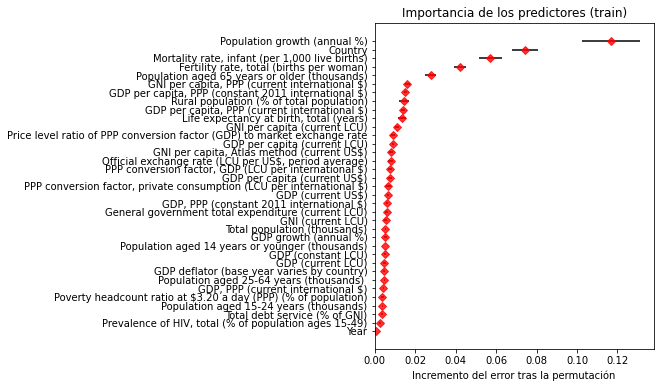

In [433]:
fig, ax = plt.subplots(figsize=(5, 6))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación');